# Simplification

Consider a curve which is represented as a series of points. The problem is to reduce the number of points in the series. 

The Ramer–Douglas–Peucker algorithm is widely known as a method which solves the problem. But let's tackle this problem with persistence.

## Imports

In [1]:
%cd ..

/home/snopoff/Documents/MIPT/Thesis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp_rec
from src.topology import topo_simplification
from sklearn.preprocessing import StandardScaler

## Data

As data, let's consider several time series which represent the closing price of QQQ and SPY funds for 10-year long history and the price BTC-USD for 7-year long history.

Shapes of data are:  (2517,) (2517,) (2920,)


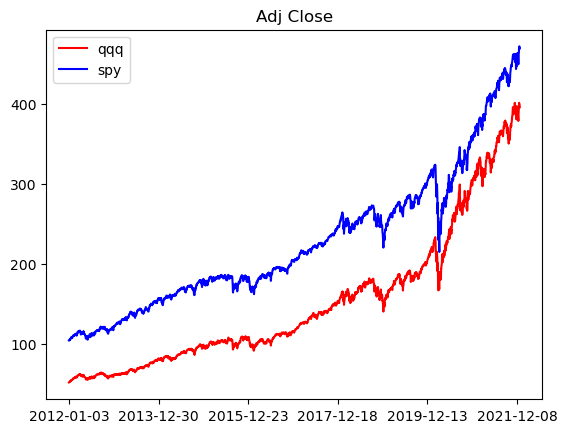

In [3]:
qqq = pd.read_csv('notebooks/data/QQQ.csv').set_index('Date')
spy = pd.read_csv('notebooks/data/SPY.csv').set_index('Date')
btc = pd.read_csv('notebooks/data/BTC-USD.csv').set_index('Date')
qqq_close = qqq['Adj Close']
spy_close = spy['Adj Close']
btc_close = btc['Adj Close']
print('Shapes of data are: ', spy_close.shape, qqq_close.shape, btc_close.shape)
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(spy_close, c='b', label='spy')
plt.xticks(range(0,2517,500))
plt.title('Adj Close')
plt.legend(loc='best')

## Ramer-Douglas-Peucker

The Ramer-Douglas-Peucker algorithm does the following: given a curve that consists of the line segments, it looks for the similar curve with fewer points. The algorithm recursively divides the line. Initially it is given all the points between the first and last point. It automatically marks the first and last point to be kept. It then finds the point that is farthest from the line segment with the first and last points as end points; this point is obviously farthest on the curve from the approximating line segment between the end points. If the point is closer than $\varepsilon$ to the line segment, then any points not currently marked to be kept can be discarded without the simplified curve being worse than $\varepsilon$. 

In [4]:
def compute_rdp(ts, eps=1):
    data = np.vstack([np.array(range(0,ts.shape[0])), ts.to_numpy()]).T
    rdp_res = rdp_rec(data, eps)
    res = ts[list(map(int,rdp_res[:,0]))].sort_index()
    return res

In [5]:
qqq_rdp = compute_rdp(qqq_close)
qqq_rdp.shape

(741,)

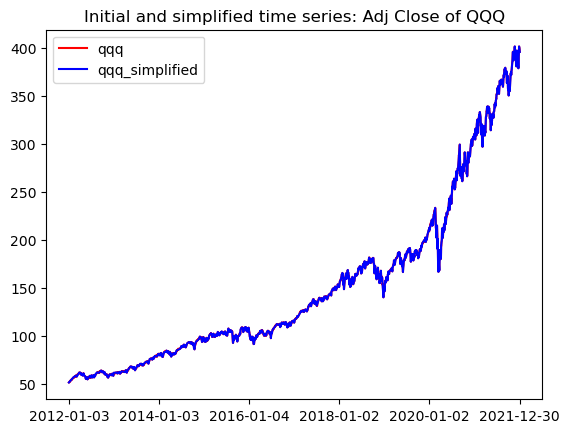

In [6]:
xticks_range = qqq_close.shape[0]
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(qqq_rdp, c='b', label='qqq_simplified')
plt.xticks(range(0, xticks_range, xticks_range // 5))
#plt.xticks(range(0,2517,500))
plt.title('Initial and simplified time series: Adj Close of QQQ')
plt.legend(loc='best')

## Topological Simplification

In [7]:
qqq_top = topo_simplification(qqq_close, distance_to_diagonal=12)
qqq_top.shape

(44,)

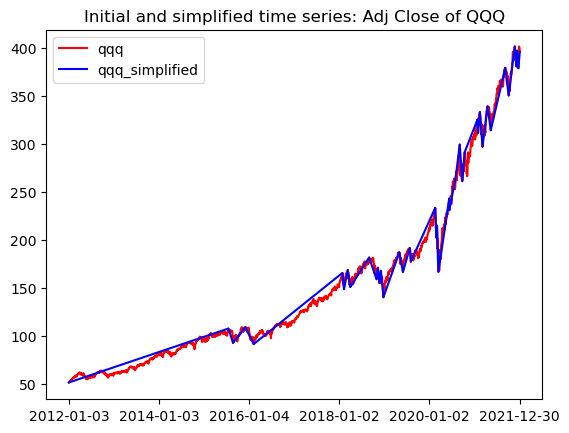

In [8]:
xticks_range = qqq_close.shape[0]
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(qqq_top, c='b', label='qqq_simplified')
plt.xticks(range(0, xticks_range, xticks_range // 5))
#plt.xticks(range(0,2517,500))
plt.title('Initial and simplified time series: Adj Close of QQQ')
plt.legend(loc='best')

## Comparison

Let's make a comparison: estimate the quality of simplification via `MSE` of RDP and Topo algorithms

In [9]:
def mse(ts, simpl_ts):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    def find_nearest(array,value):
        idx = np.searchsorted(array, value, side="left")
        if idx > 0 and idx != array.shape[0]:
            return (array[idx-1], array[idx])
        if idx == array.shape[0]:
            return array[idx-1], array[idx-1]
        else:
            return 0, array[idx]
        
    res_value = 0
    for ind in ts.index:
        if ind not in simpl_ts.index:
            ind_left, ind_right = find_nearest(simpl_ts.index, ind)
            value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)
            res_value += (value_at_ind - float(ts[ind]))**2
            
    return res_value / ts.shape[0]

In [10]:
data = {'QQQ': qqq_close.reset_index()['Adj Close'], 'SPY': spy_close.reset_index()['Adj Close'], 'BTC': btc_close.reset_index()['Adj Close']}

In [11]:
%%time
results_rdp = {}
results_topo = {}
for name, d in data.items():
    rng = np.linspace(0,np.sqrt(d.max()), 40)
    results_rdp[name] = (np.zeros_like(rng),np.zeros_like(rng))
    results_topo[name] = (np.zeros_like(rng),np.zeros_like(rng))
    for i, eps in enumerate(rng):
        print(name, eps)
        rdp = compute_rdp(d,eps)
        topo = topo_simplification(d, distance_to_diagonal=eps)
        topo_mse = mse(d, topo)
        rdp_mse = mse(d, rdp)
        results_topo[name][1][i] = topo_mse
        results_rdp[name][1][i] = rdp_mse
        results_topo[name][0][i] = topo.shape[0]
        results_rdp[name][0][i] = rdp.shape[0]
        print("Dataset is {}\t rdp MSE = {}\t topo MSE = {}".format(name, rdp_mse, topo_mse))
        print("Number of points in rdp = {}\t in topo = {}".format(rdp.shape[0], topo.shape[0]))

QQQ 0.0
Dataset is QQQ	 rdp MSE = 1.7348546286548191e-28	 topo MSE = 0.9289678518061538
Number of points in rdp = 2516	 in topo = 1240
QQQ 0.5137729507967642
Dataset is QQQ	 rdp MSE = 0.12074549566199869	 topo MSE = 1.3722812193019072
Number of points in rdp = 1233	 in topo = 741
QQQ 1.0275459015935284
Dataset is QQQ	 rdp MSE = 0.49185386207165477	 topo MSE = 1.8749913977622152
Number of points in rdp = 719	 in topo = 558
QQQ 1.5413188523902925
Dataset is QQQ	 rdp MSE = 0.8705542505559941	 topo MSE = 2.650663548380298
Number of points in rdp = 519	 in topo = 427
QQQ 2.055091803187057
Dataset is QQQ	 rdp MSE = 1.3966898955046114	 topo MSE = 3.3470506343940296
Number of points in rdp = 390	 in topo = 344
QQQ 2.568864753983821
Dataset is QQQ	 rdp MSE = 1.8265905550212929	 topo MSE = 3.8005718128379855
Number of points in rdp = 311	 in topo = 293
QQQ 3.082637704780585
Dataset is QQQ	 rdp MSE = 2.5173392687476133	 topo MSE = 4.355972638160394
Number of points in rdp = 244	 in topo = 245
QQQ

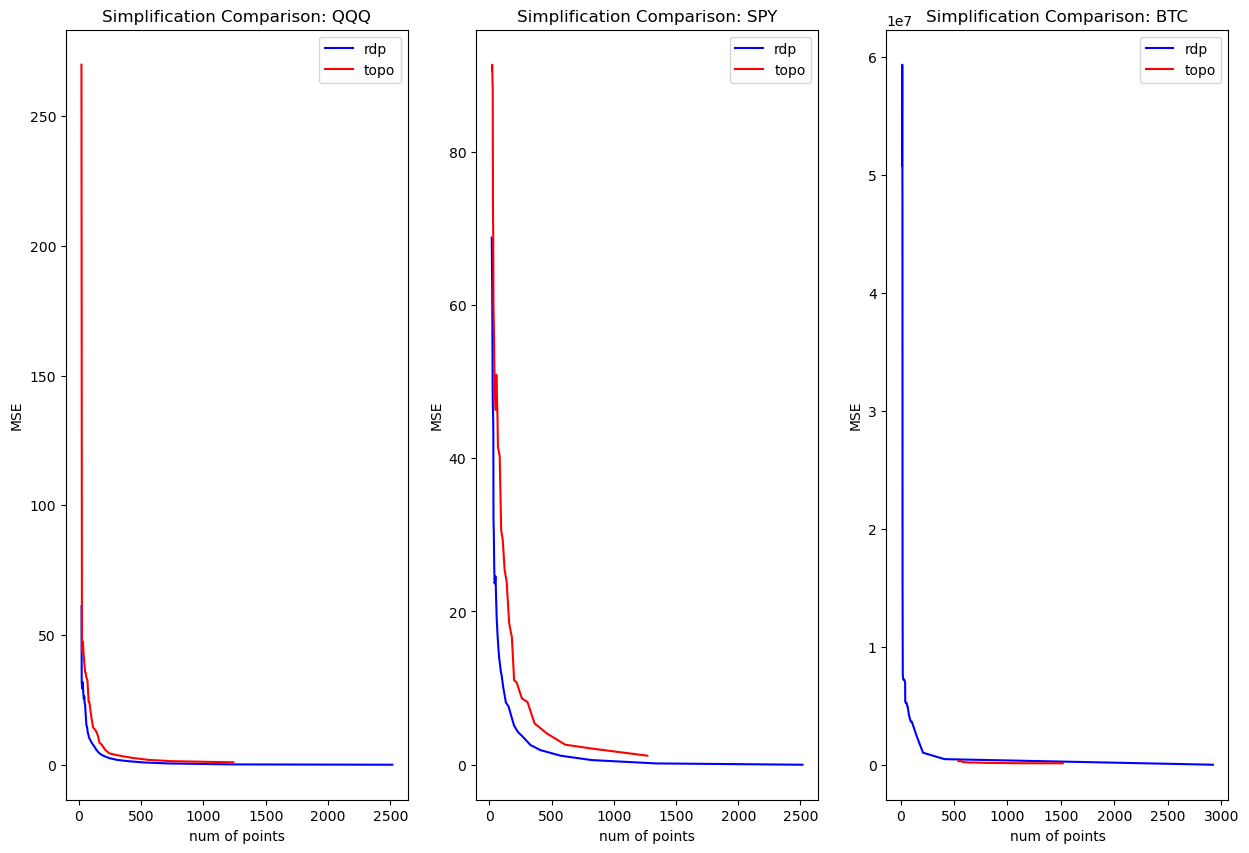

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()
for i, name in enumerate(data.keys()):
    axs[i].plot(results_rdp[name][0], results_rdp[name][1], c='b', label='rdp')
    axs[i].plot(results_topo[name][0], results_topo[name][1], c='r', label='topo')
    axs[i].set_xlabel('num of points')
    axs[i].set_ylabel('MSE')
    axs[i].set_title('Simplification Comparison: {}'.format(name))
    axs[i].legend(loc="best")

In [61]:
topo_simplification(btc_close, distance_to_diagonal=0.5, plot_diagram=True)

AttributeError: 'Series' object has no attribute 'reshape'

In [67]:
StandardScaler().fit_transform(btc_close.to_numpy().reshape(1,-1)).nunique()

AttributeError: 'numpy.ndarray' object has no attribute 'nunique'